Columns: ['ชื่อ', 'ระยะเวลา', 'ข้อความรีวิว']

Label distribution before adjustment:
label
positive    128
neutral      21
negative      1
Name: count, dtype: int64

Label distribution after merging:
label
positive    128
neutral      22
Name: count, dtype: int64

=== SVM Performance ===
              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00         4
    positive       0.87      1.00      0.93        26

    accuracy                           0.87        30
   macro avg       0.43      0.50      0.46        30
weighted avg       0.75      0.87      0.80        30

Confusion Matrix:
[[ 0  4]
 [ 0 26]]

SVM Accuracy: 0.8667


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


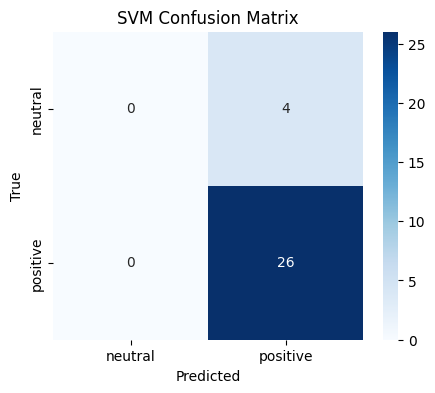


Saved predictions to: /content/ReviewKruaBanPaBoon_SVM_results.csv


In [2]:
# =======================================
#  STEP 1: Import libraries
# =======================================
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# =======================================
#  STEP 2: Load CSV file
# =======================================
path = "/content/ReviewKruaBanPaBoon.csv"  # <- แก้ path ถ้าไฟล์อยู่ที่อื่น
df = pd.read_csv(path, encoding="utf-8", dtype=str, engine="python").fillna("")
print("Columns:", list(df.columns))
df.head()

# =======================================
#  STEP 3: Weak labeling (ใช้คำบวก/ลบ)
# =======================================
positive_words = ["อร่อย","ดีมาก","ดี","ชอบ","อร่อยมาก","แนะนำ","อร่อยสุด","สด","ถูกใจ","ประทับใจ","เด็ด","คุ้ม","ถูก"]
negative_words = ["ไม่อร่อย","แย่","แพง","ไม่ดี","เสียใจ","ผิดหวัง","บริการแย่","รสจืด","ห่วย","ไม่โอเค","ไม่ประทับใจ","สกปรก","เก่า"]

def weak_label(text):
    t = str(text).lower()
    pos = any(w in t for w in positive_words)
    neg = any(w in t for w in negative_words)
    if pos and not neg:
        return "positive"
    elif neg and not pos:
        return "negative"
    else:
        return "neutral"

source_col = "ข้อความรีวิว"
df["label"] = df[source_col].apply(weak_label)
print("\nLabel distribution before adjustment:")
print(df["label"].value_counts())

# =======================================
#  STEP 4: Combine rare classes
# =======================================
# รวม negative เข้ากับ neutral เพราะ negative มีแค่ 1 ตัว
df["label"] = df["label"].replace("negative", "neutral")
print("\nLabel distribution after merging:")
print(df["label"].value_counts())

# =======================================
#  STEP 5: Split train/test
# =======================================
X_train, X_test, y_train, y_test = train_test_split(
    df[source_col], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

# =======================================
#  STEP 6: Prepare TF-IDF + SVM model
# =======================================
vectorizer = TfidfVectorizer(analyzer="char_wb", ngram_range=(1,4), max_features=20000)
svm_pipeline = make_pipeline(vectorizer, LinearSVC())

# เทรนโมเดล
svm_pipeline.fit(X_train, y_train)

# =======================================
#  STEP 7: Evaluate model
# =======================================
svm_preds = svm_pipeline.predict(X_test)

print("\n=== SVM Performance ===")
print(classification_report(y_test, svm_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, svm_preds))

acc_svm = accuracy_score(y_test, svm_preds)
print(f"\nSVM Accuracy: {acc_svm:.4f}")

# =======================================
#  STEP 8: Visualize confusion matrix
# =======================================
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, svm_preds), annot=True, fmt="d", cmap="Blues",
            xticklabels=svm_pipeline.classes_, yticklabels=svm_pipeline.classes_)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# =======================================
#  STEP 9: Save predictions
# =======================================
df_test = pd.DataFrame({
    "ข้อความรีวิว": X_test,
    "True_Label": y_test,
    "SVM_Predict": svm_preds
})
out_path = "/content/ReviewKruaBanPaBoon_SVM_results.csv"
df_test.to_csv(out_path, index=False, encoding="utf-8-sig")
print("\nSaved predictions to:", out_path)